# Spike Tutorial -- Part 2

## Analyzing Populations 1

In part 1 we had to do quite a bit of work to get our data in a workable format. Now that we understand the data structures and how to manipulate them, we can focus more on scientific questions. In this tutorial, the focus will be on analyzing multiple neurons and organizing and analyzing that data. There are many ways to do this in Matlab, and it seems like even more in Python, so we'll explore a few of them.

First import our favorite modules!

In [5]:
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle

%matplotlib inline

We pickled our session info. from last time, let's load it up:

In [6]:
root = '_data'
fn = os.path.join(root,'sessionInfo.pkl')

with open(fn,'rb') as f:
    [order, clustInfo, fs, stimOn, laserOn] = pickle.load(f)

Ok, we have almost everything we need except our spikes. Load the `'spike_times.npy'` and `'spike_clusters.npy'` to `spikes` and `clust`, respectively. Convert your spikes to seconds using `fs`.

In [7]:
# load spikes and clusters
spikes = np.load(os.path.join(root,'spike_times.npy')) / fs
clust = np.load(os.path.join(root,'spike_clusters.npy'))

We have all of our raw data, lets use what we learned from last time to make PSTHs and rasters for each cell! Because we need to make a PSTH for every neuron, we should write a function to do that. Write a function called `makePSTH` that takes 3 inputs: `spikes`, `triggers`, `edges` and returns `psth`, `raster` and `trials`.

TIP: make the function as general as possible... to compute the firing rate per bin you need to divide by the bin time. Is there a way to do that from just the three variables we've passed?

In [8]:
# makePSTH function
def makePSTH(spikes,triggers,edges):
    
    # preallocate
    raster = []
    trials = []
    psth = np.empty([len(triggers),len(edges)-1])

    for i,trig in enumerate(triggers):

        # zero spikes
        spks = spikes - trig

        # spike histogram appended to PSTH
        psth[i,:],_ = np.histogram(spks,bins=edges)
        psth[i,:] = psth[i,:] / np.diff(edges).mean()

        # extend raster (using only spikes within each trial range)
        spks = spks[(spks>edges[0]) & (spks<edges[-1])]
        raster.extend(spks)
        trials.extend(np.ones(len(spks))*(i+1))
    
    return [psth,raster,trials]
        

Like last time, lets define `edges` in steps of .001 between -.1 and 3.1s, and then define a vector called `time` with the edge centers. Take some spikes from unit 26 and use your function to make `psth`, `raster`, and `trials`. Scatter plot the raster to make sure this worked well.

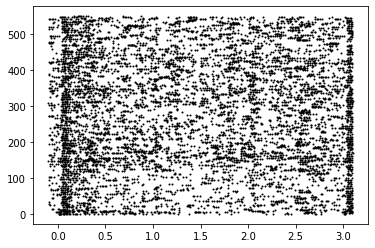

In [9]:
# compute psth, raster
c = 26
edges = np.arange(-.1,3.1,.001)
time = edges[:-1] + np.diff(edges).mean()/2
psth,raster,trials = makePSTH(spikes[clust==c],stimOn,edges)

# plot
plt.scatter(raster,trials,1,'k')

Next we want to compute PSTHs for all of our neurons and save them to a data struct. There are a lot of ways to do this, but the way we can first try is by saving them in a 3d array (that is, n trials x m timepoints x p neurons).

**Try this:**
1. Make an **array** called `cellID` that contains the unique cell ID numbers for all our our neurons in `clustInfo`.
2. Loop through this variable. On each loop, extract spikes for that cell and use your PSTH function to make a PSTH (don't make raster,trials for now)
3. Save each cell's PSTH to a new matrix called `allPSTH`, like described above. Remember to preallocate an **empty** version of this matrix.
4. This might take a little while to run, print the iteration each time the loop runs to keep track of your progress.

In [10]:
cellID = np.asarray(clustInfo.id)
allPSTH = np.empty([len(stimOn),len(edges)-1,len(cellID)])

for i,ID in enumerate(cellID):
    
    cSpks = spikes[clust == ID]
    
    allPSTH[:,:,i],_,_ = makePSTH(cSpks,stimOn,edges)
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


The benefit of putting everything in an array is that we can really easily index and average data using numpy. 

**Try this:**
1. As a first pass, make an index for laser ON/OFF trials.
2. Then index `allPSTH` and average to find the mean response over all neurons when the laser is on vs when it is off. You can save your responses to `meanLaserOff` and `meanLaserOn`. HINT: you need to average over more than 1 dimension!
3. Plot these cell averages on top of each other. Give them a legend and axis labels.

Text(0, 0.5, 'FR (Hz)')

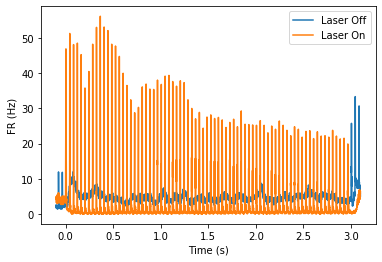

In [11]:
# index and means
I = order[:,1]==1

meanLaserOff = allPSTH[~I,:,:].mean(axis=2).mean(axis=0)
meanLaserOn = allPSTH[I,:,:].mean(axis=2).mean(axis=0)

# plot
plt.plot(time,meanLaserOff)
plt.plot(time,meanLaserOn)
plt.legend(['Laser Off','Laser On'])
plt.xlabel('Time (s)')
plt.ylabel('FR (Hz)')

Woah! It should look pretty funky, with the laserOn plot having very stereotyped bursting activity. This is because the laser was pulsed at 25Hz and it looks like there are some optotagged units in this recording! (that means that the unit will be activated on each laser pulse).

Lets try to separate these units out from the rest.

**Try this:**
1. Compute new averages, averaging over the entire trace on laser off vs laser on trials for each cell. Your ending vectors will be length of the number of neurons, 49. Call them `cellLaserOff` and `cellLaserOn`.
2. Compute a difference vector, subtracting the firing rate when the laser is off from when it is on, call this `dLaser`

In [12]:
# compute the average response difference between laser off and laser on trials for each neuron
cellLaserOff = allPSTH[~I,:,:].mean(axis=0).mean(axis=0)
cellLaserOn = allPSTH[I,:,:].mean(axis=0).mean(axis=0)
dLaser = cellLaserOn - cellLaserOff

Now you can use `dLaser` as an index to separate cells that are activated by the laser vs suppressed by the laser.

1. Make two new PSTHs, one called `supPSTH` which contains neurons that are suppressed by laser, and another called `actPSTH` which contains only activated neurons.
2. Get the population means for laser on and off trials for each of these sets of neurons.
3. On two subplots, plot laser on vs laser off traces for each population. Color the activated subplot in black for laser off and black, dashed lines for on. Do the same for the suppressed neurons subplot, but in blue.

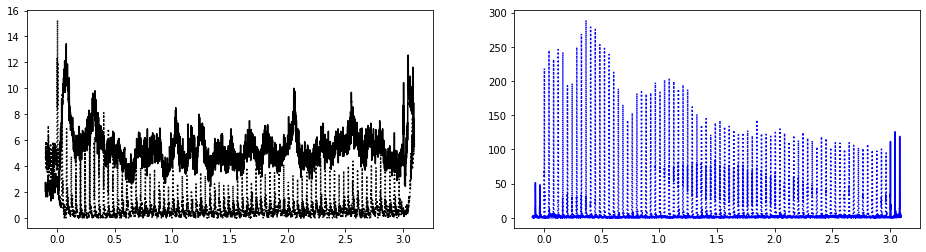

In [13]:
# separate out these cells into new PSTH matrices for optotagged vs suppressed neurons
supPSTH = allPSTH[:,:,dLaser<0]
actPSTH = allPSTH[:,:,dLaser>0]

# get new means
mSupOff = supPSTH[~I,:,:].mean(axis=2).mean(axis=0)
mSupOn = supPSTH[I,:,:].mean(axis=2).mean(axis=0)

mActOff = actPSTH[~I,:,:].mean(axis=2).mean(axis=0)
mActOn = actPSTH[I,:,:].mean(axis=2).mean(axis=0)

# plot
fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(time,mSupOff,'k')
ax[0].plot(time,mSupOn,'k:')

ax[1].plot(time,mActOff,'b')
ax[1].plot(time,mActOn,'b:')

This simple way of filtering the data looks like it did an ok job of filtering out the different cell types. However, it's not perfect (see in the laser on condition in suppressed cells, there is still some laser-locked activity). Maybe we can try to refine this method a bit by using statistical tests to tell whether a cell significantly changes its activity.

We can do this by using a sign rank test for each cell, across all trials, and then asking whether the difference is significant, and in what direction. We can use the ranksums function in the scipy.stats module to do this.

In [14]:
import scipy.stats

# get a mean per trial for one neuron
c = 32

# before, we just averaged over the whole timecourse... this time, let's select a time window
tInd = (time > 0) & (time < 1)

# make a cell PSTH (squeeze to remove the empty dimension)
cPSTH = allPSTH[:,:,cellID == c].squeeze()

# keep only our time window of interest
cPSTH = cPSTH[:,tInd]

# run the ranksum test between laser ON and OFF, where variability is across trials
f,p = scipy.stats.ranksums(cPSTH[I,:].mean(axis=1),cPSTH[~I,:].mean(axis=1))

Here, f and p are results of the test. In our case, f is the test statistic, and its sign will indicate whether the cell was activated by laser (positive f) or suppressed (negative). The p value tells us if our cell was significantly modulated by laser.

That said, we want information for each cell. Use a for loop to calculate the test statistics and p-values for all the neurons. Save your results to variables called `fVal` and `pVal`.

In [15]:
fVal = np.empty(cellID.shape)
pVal = np.empty(cellID.shape)

for i,c in enumerate(cellID):
    
    # make a cell PSTH (squeeze to remove the empty dimension)
    cPSTH = allPSTH[:,:,cellID == c].squeeze()

    # keep only our time window of interest
    cPSTH = cPSTH[:,tInd]
    
    fVal[i],pVal[i] = scipy.stats.ranksums(cPSTH[I,:].mean(axis=1),cPSTH[~I,:].mean(axis=1))

Now we have another cell selection criteria we can use, whether the cell was significantly modulated by laser. However, we just ran quite a few tests, by chance some of the tests will be false positives. There are many ways to correct for this, but lets use the simplest one that is also quite strict, the Bonferonni correction, which just states that our new significance value is our previous criterion for significance, divided by the number of tests we ran.

In [16]:
alpha = .05 / len(cellID)
print(alpha)

0.0010204081632653062


Using this new criterion, nearly all of the cells are still significant (this is probably due to the large number of trials we had). By my count, only one cell failed the test, lets look at that cell:

**try this:**
1. Make an index that finds cells violating our corrected alpha level, call it `pI`.
2. Plot the average traces for this cell, does the test result make sense to you?

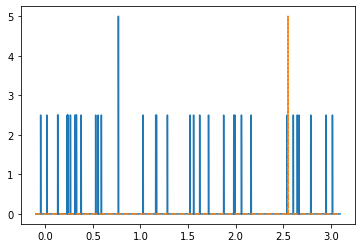

In [17]:
pI = pVal > alpha
cPSTH = allPSTH[:,:,pI].squeeze()
plt.plot(time,cPSTH[~I,:].mean(axis=0),'-')
plt.plot(time,cPSTH[I,:].mean(axis=0),'--')

It looks like that previous cell didn't have much activity, so it probably had quite a bit of variability over trials that contributed to it failing the test.

So far, we've organized our data in arrays, but once we get to this population level, maybe panda dataframes are a useful way to organize and select neurons for analysis, we'll try this in the next tutorial.

In [18]:
clustInfo.head()

,id,Amplitude,ContamPct,KSLabel,channel,depth,firing_rate,group,n_spikes
0,1,488.6,100.0,mua,1,725.0,2.3 spk/s,good,7405
1,2,315.0,100.0,mua,1,725.0,2.5 spk/s,mua,8180
2,3,420.4,100.0,mua,1,725.0,1.8 spk/s,mua,5769
7,14,467.6,100.0,mua,21,400.0,1.2 spk/s,mua,3776
8,15,222.6,100.0,mua,21,400.0,3.1 spk/s,mua,9953


Next, lets try adding information to this data frame about the activity of our neurons. First, make a `.copy()` of your dataframe called `cellData` and add columns for the results of our ranksum test, we'll call them `laserFval`, `laserPval` and `laserSig` for the f values, p values, and significant pvals respectively.

In [19]:
cellData = clustInfo.copy()
cellData['laserFval'] = fVal
cellData['laserPval'] = pVal
cellData['laserSig'] = pVal < alpha

Let's also add some information about the activity of each cell in each condition. We have 2x2 conditions, laser On/Off and contrast Low/High. Let's populate new columns in our matrix with the mean firing rate in each unique condition, calling our columns `frLowOFF`, `frLowON`, `frHighOff`, `frHighON`.

**Try this:**
1. Create indices for all 4 conditions.
2. Loop through each neuron, get the mean firing rate from 0 - 3s for each unique condition.
3. Add the new data to the columns mentioned above.

In [20]:
lowOffI = (order[:,0] == 1) & (order[:,1] == 0)
lowOnI = (order[:,0] == 1) & (order[:,1] == 1)
highOffI = (order[:,0] == 2) & (order[:,1] == 0)
highOnI = (order[:,0] == 2) & (order[:,1] == 1)

# index out the time period we want
tPSTH = allPSTH[:,(time>0)&(time<3),:]

# for each neuron, find mean fr in each condition
frLowOff = []
frLowOn = []
frHighOff = []
frHighOn = []
for i,c in enumerate(cellID):
    
    # index the cell and make a temporary PSTH
    cPSTH = tPSTH[:,:,i].squeeze()
    
    # condition means
    frLowOff.append(cPSTH[lowOffI,:].mean().mean())
    frLowOn.append(cPSTH[lowOnI,:].mean().mean())
    frHighOff.append(cPSTH[highOffI,:].mean().mean())
    frHighOn.append(cPSTH[highOnI,:].mean().mean())
    
# add to data frame
cellData['frLowOff'] = frLowOff
cellData['frLowOn'] = frLowOn
cellData['frHighOff'] = frHighOff
cellData['frHighOn'] = frHighOn

Ok, remember before when we wanted to test whether a neuron was significantly affected by the laser? This can come in handy now when we want to summarize data across the population. Common practice is to exclude cells that are either non-responsive, have low firing rates, etc.

The nice thing about the dataframe object is that we have all the information about our cells in one place, and it makes it simple to filter out neurons depending on your criteria.

**Try this:**
1. First create a copy of your unfiltered dataframe called `cellData_orig`, in case you want to revert back to your original data.
2. While we could filter by our ranksum test results, looking at the data you can see quite a few cells with very low firing rates, less than 1Hz. For now, lets modify `cellData` to remove cells with a rate below 1Hz. 
3. Note that the `firing_rate` column is a string format, to deal with this you will need to split this column and convert to a floating point number. I managed to do this in one messy line, but feel free to make masks/take whatever strategy you want.

In [21]:
cellData_orig = cellData.copy()
#cellData = cellData_orig.copy()

cellData[cellData['firing_rate'].str.split(' ',expand=True)[0].astype(float) > 1]

,id,Amplitude,ContamPct,KSLabel,channel,depth,firing_rate,group,n_spikes,laserFval,laserPval,laserSig,frLowOff,frLowOn,frHighOff,frHighOn
0,1,488.6,100.0,mua,1,725.0,2.3 spk/s,good,7405,-15.679939,2.074539e-55,True,4.898333,0.053333,2.251667,0.076667
1,2,315.0,100.0,mua,1,725.0,2.5 spk/s,mua,8180,17.878358,1.738843e-71,True,0.250000,8.900000,0.220000,7.950000
2,3,420.4,100.0,mua,1,725.0,1.8 spk/s,mua,5769,-15.567782,1.205137e-54,True,2.673333,0.076667,2.141667,0.053333
7,14,467.6,100.0,mua,21,400.0,1.2 spk/s,mua,3776,-9.823317,8.935375e-23,True,1.288333,0.010000,0.940000,0.000000
8,15,222.6,100.0,mua,21,400.0,3.1 spk/s,mua,9953,7.923899,2.301757e-15,True,2.373333,1.660000,1.665000,1.603333
11,20,358.9,100.0,mua,5,475.0,2.9 spk/s,mua,9495,-15.938473,3.426216e-57,True,4.840000,0.526667,3.845000,0.316667
14,23,276.6,100.0,mua,6,675.0,3.8 spk/s,mua,12418,10.207497,1.835378e-24,True,2.903333,7.013333,2.788333,7.540000
15,25,355.1,100.0,mua,7,775.0,3.9 spk/s,mua,12749,-17.700756,4.137197e-70,True,7.826667,0.036667,5.966667,0.030000
16,26,639.2,100.0,mua,7,775.0,3.5 spk/s,good,11283,-16.143303,1.265825e-58,True,7.550000,0.050000,4.071667,0.076667
19,31,384.0,100.0,mua,9,275.0,2.2 spk/s,mua,7301,-10.484517,1.017648e-25,True,2.133333,0.000000,1.753333,0.003333


First lets make a scatterplot to summarize the effect of our conditions on firing rate. 

**Try this:**
1. Scatter plot the laser off (x) vs laser on (y) seprately for low and high contrast. Color the points to indicate the contrast condition (red for high, blue for low).
2. Add a unity line from [0 0] to [25 25]
3. Add a legend, axis labels, and title

**Bonus:** the current plot has two dots for each cell, one for low and one for high contrast.  To visualize the contrast change, plot lines between each red and blue dot to indicate cell identity. Make sure the lines are underneath (ie. occluded by) the scatter points (look up zorder).

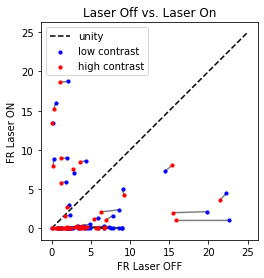

In [22]:
plt.plot([0,25],[0,25],'k--',zorder=1)
plt.scatter(cellData['frLowOff'],cellData['frLowOn'],10,'b',zorder=3)
plt.scatter(cellData['frHighOff'],cellData['frHighOn'],10,'r',zorder=3)
#plt.gca().set_aspect('equal', adjustable='box')
plt.axis('scaled')
plt.legend(['unity','low contrast','high contrast'])
plt.title('Laser Off vs. Laser On')
plt.xlabel('FR Laser OFF')
plt.ylabel('FR Laser ON')


# bonus
x = pd.concat([cellData['frLowOff'],cellData['frHighOff']],axis=1)
y = pd.concat([cellData['frLowOn'],cellData['frHighOn']],axis=1)
plt.plot(np.transpose(np.asarray(x)),np.transpose(np.asarray(y)),'k',zorder=2,alpha=.5)

In the plot above, you can see that nearly all the neurons are suppressed, with the exception of those above the unity line. If you draw lines identifying each neuron, you can also see that high contrast generally elicits lower firing rates, as most of the red dots are shifted towards zero, relative to the blue dots.

We can also plot the data another way, where we our axes are the effect of contrast.

**Try this:**
Recreate the same plot, but scatter low vs. high contrast and color the dots black for no laser and cyan for laser. As usual, add a legend, title, and axis labels.

As a **bonus**, you can also add lines connecting each cell, but set their transparency to .3.

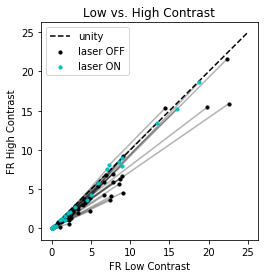

In [23]:
plt.plot([0,25],[0,25],'k--',zorder=1)
plt.scatter(cellData['frLowOff'],cellData['frHighOff'],10,'k',zorder=3)
plt.scatter(cellData['frLowOn'],cellData['frHighOn'],10,'c',zorder=3)
#plt.gca().set_aspect('equal', adjustable='box')
plt.axis('scaled')
plt.legend(['unity','laser OFF','laser ON'])
plt.title('Low vs. High Contrast')
plt.xlabel('FR Low Contrast')
plt.ylabel('FR High Contrast')


# bonus
x = pd.concat([cellData['frLowOff'],cellData['frLowOn']],axis=1)
y = pd.concat([cellData['frHighOff'],cellData['frHighOn']],axis=1)
plt.plot(np.transpose(np.asarray(x)),np.transpose(np.asarray(y)),'k',zorder=2,alpha=.3)

Remember we had a bunch of neurons that were optotagged? We may want to remove those from our current analysis to look only at the effect of activating VGAT neurons on excitatory cells.

**Try this:**
1. Filter `cellData` to remove cells that are activated by the laser.
2. Replot the previous two graphs with our newly filtered data, but make them subplots this time.

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

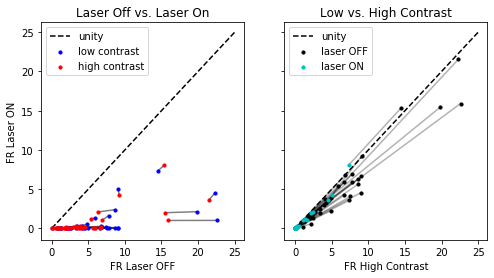

In [24]:
# filter out activated neurons
cellData = cellData[cellData['laserFval'] < 0]
cellData

# plots
fig,ax = plt.subplots(1,2,figsize=[8,4],sharex=True,sharey=True)
ax[0].plot([0,25],[0,25],'k--',zorder=1)
ax[0].scatter(cellData['frLowOff'],cellData['frLowOn'],10,'b',zorder=3)
ax[0].scatter(cellData['frHighOff'],cellData['frHighOn'],10,'r',zorder=3)
ax[0].legend(['unity','low contrast','high contrast'])
ax[0].set_title('Laser Off vs. Laser On')
ax[0].set_xlabel('FR Laser OFF')
ax[0].set_ylabel('FR Laser ON')
x = pd.concat([cellData['frLowOff'],cellData['frHighOff']],axis=1)
y = pd.concat([cellData['frLowOn'],cellData['frHighOn']],axis=1)
ax[0].plot(np.transpose(np.asarray(x)),np.transpose(np.asarray(y)),'k',zorder=2,alpha=.5)

ax[1].plot([0,25],[0,25],'k--',zorder=1)
ax[1].scatter(cellData['frLowOff'],cellData['frHighOff'],10,'k',zorder=3)
ax[1].scatter(cellData['frLowOn'],cellData['frHighOn'],10,'c',zorder=3)
ax[1].legend(['unity','laser OFF','laser ON'])
ax[1].set_title('Low vs. High Contrast')
ax[1].set_xlabel('FR Low Contrast')
ax[1].set_xlabel('FR High Contrast')
x = pd.concat([cellData['frLowOff'],cellData['frLowOn']],axis=1)
y = pd.concat([cellData['frHighOff'],cellData['frHighOn']],axis=1)
ax[1].plot(np.transpose(np.asarray(x)),np.transpose(np.asarray(y)),'k',zorder=2,alpha=.3)

plt.tight_layout

So far we've visualized our data, but what about running statistics?

To look at the joint effect of contrast and laser on firing rate, the best test to run is a repeated measures, two-way ANOVA. This is because we are measuring a firing rate for each of our neurons in each condition. Like in Matlab, this is kind of a pain to do... we're going to need to reformat our data and also install a special package to do it.

Most repeated measures ANOVA packages that I could find take pandas dataframes as inputs, where one column is the dependent variable (firing rate), one column is the subject (cell ID), and each other column is an independent variable (for us, laser and contrast). 

While we do have our data in a dataframe already, the formatting is not quite right... we need to reformat it so that each row isn't all the info for a neuron, but contains the mean firing rate for a specific condition, and labels indicating the condition as well as cell ID. So, because we have 4 conditions, our new data frame should have 4 x nNeurons rows. For example, for the our first neuron, the dataframe should look something like this: 
<img src="cellDF.png">



To make this, I found it easiest to make lists called `cell`, `FR`, `laser`, and `contrast`, then looped through each neuron and each of the 4 conditions to append to these lists. I'll give you some useful variables that you may use in your loop

In [25]:
colLabels = ['frLowOff','frLowOn','frHighOff','frHighOn']
laserLabels = ['off','on','off','on']
contrastLabels = ['low','low','high','high']

# make lists in loop
cell = []
FR = []
laser = []
contrast = []
# for each neuron
for i,c in enumerate(cellData.index):
    
    # for each condition
    for j,l in enumerate(colLabels):
        
        # append the data
        cell.append(c)
        FR.append(cellData[l].iloc[i])
        laser.append(laserLabels[j])
        contrast.append(contrastLabels[j])
   
# add lists to data frame
df = pd.DataFrame(columns=['cell','FR','laser','contrast'])
df['cell'] = cell
df['FR'] = FR
df['laser'] = laser
df['contrast'] = contrast

Ok, that was a pain... now we're ready to do an ANOVA. First we need to install a new package using `pip`, python's package installation tool.

You can either run the following in your terminal:
`pip install pingouin`

Or running the next cell should also work, using a magic (%) command

In [26]:
%pip install pingouin

Note: you may need to restart the kernel to use updated packages.


Now we can import the package and run the ANOVA. If this step doesn't work, you may need to restart your kernel to access the newly installed package.

In [27]:
import pingouin as pg

To run the anova, we'll use the `rm_anova` function in pingouin, you can either look at the help or use google to figure out how to format this command. Basically, we want to test whether the independent variables `laser` and `contrast` affect our dependent variable `FR` over repeated measures in `cell`

In [28]:
# anova
rmAnova = pg.rm_anova(dv='FR', within=['laser', 'contrast'], subject='cell', data=df)
print(rmAnova)

             Source          SS  ddof1  ddof2          MS          F  \
0             laser  883.051500      1     38  883.051500  49.154326   
1          contrast   20.096582      1     38   20.096582  33.145850   
2  laser * contrast   16.952119      1     38   16.952119  28.323268   

          p-unc     p-GG-corr       np2  eps  
0  2.376363e-08  2.376363e-08  0.563992  1.0  
1  1.225745e-06  1.225745e-06  0.465886  1.0  
2  4.837605e-06  4.837605e-06  0.427049  1.0  


We can also run post hoc tests, look at the methods in `pg` to see what command to use for this.

In [29]:
# post-hoc tests
postHoc = pg.pairwise_ttests(dv='FR', within=['laser', 'contrast'], subject='cell', data=df)
print(postHoc)

           Contrast laser    A     B Paired  Parametric         T   dof  \
0             laser     -  off    on   True        True  7.011015  38.0   
1          contrast     -  low  high   True        True  5.757243  38.0   
2  laser * contrast   off  low  high   True        True  5.607365  38.0   
3  laser * contrast    on  low  high   True        True  1.527216  38.0   

        Tail         p-unc       BF10    hedges  
0  two-sided  2.376363e-08  5.691e+05  1.247227  
1  two-sided  1.225745e-06  1.414e+04  0.225554  
2  two-sided  1.967673e-06   9100.782  0.263908  
3  two-sided  1.349891e-01      0.501  0.037061  


Before we were having trouble getting rid of laser responses, so we should try to explicitly remove cells that were optotagged by looking at their laser responses, synchronized to laser onset.

In the last tutorial, we saved the laser events near the end in `laserOn`

Other things to cover:
- STRF + LN model
- SVM and other classifiers
- behavior
- opto-tagging
- model fitting
- stimulus construction

In [32]:
import lab_tools
lab_tools.makePSTH?